In [1]:
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_device", jax.devices()[0])

import jax.numpy as jnp
from KernelTools import make_block,eval_k,vectorize_kfunc,diagpart,get_selected_grad
from Kernels import get_gaussianRBF,get_centered_scaled_poly_kernel
from data_utils import build_xy_grid
from darcy_data import get_darcy_solver,sample_gp_function
from jax.random import PRNGKey as pkey
import matplotlib.pyplot as plt
from EquationModel import CholInducedRKHS,SharedOperatorPDEModel,InducedOperatorModel
from tqdm.auto import tqdm
from parabolic_data_utils import build_alpha_chebyshev
from data_utils import make_grids

In [2]:
num_functions = 5
samples_per_function = 10
collocation_grid_n = 10

obs_random_keys = jax.random.split(pkey(32),num_functions)
xy_obs = tuple(jax.random.uniform(key,(samples_per_function,2),minval = 0.,maxval = 1.) for key in obs_random_keys)


kernel_f = get_gaussianRBF(0.15)
key = pkey(10)
keys = jax.random.split(key,num_functions)
rhs_functions = tuple(
    sample_gp_function(subkey,kernel_f) for subkey in keys
)

grid = jnp.linspace(0,1,100)
x,y = jnp.meshgrid(grid,grid)
fine_grid = jnp.vstack([x.flatten(),y.flatten()]).T

def a(x):
    return 0.1 * jnp.exp(0.5 * jnp.sin(4*jnp.pi*x[0]*x[1]))

darcy_solve = get_darcy_solver(a,num_grid = 50,k_u = get_gaussianRBF(0.2))
u_true_functions = tuple([darcy_solve(f) for f in rhs_functions])

k_u = get_gaussianRBF(0.2)

single_grid = build_alpha_chebyshev([0,1],collocation_grid_n,1.)
xy_int,xy_bdy = make_grids(single_grid,single_grid)

xy_all = jnp.vstack([xy_int,xy_bdy])


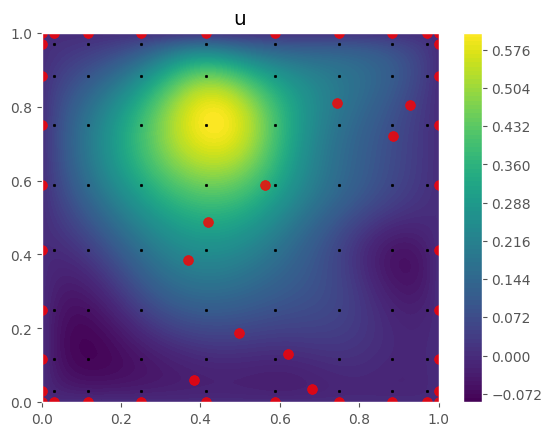

In [3]:
plt.title('u')
plt.tricontourf(fine_grid[:,0],fine_grid[:,1],jax.vmap(u_true_functions[0])(fine_grid),100)
plt.colorbar()
plt.scatter(xy_int[:,0],xy_int[:,1],c = 'black',s = 3)
plt.scatter(xy_obs[0][:,0],xy_obs[0][:,1],c = 'red',s = 50,alpha = 0.8)
plt.scatter(xy_bdy[:,0],xy_bdy[:,1],c = 'red',s = 50,alpha = 0.8)
plt.show()

In [4]:
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])
basis_operators = tuple([eval_k,diff_xx_op,diff_yy_op])

u_model = CholInducedRKHS(
    xy_all,
    basis_operators,
    k_u
)


observation_points = tuple(jnp.vstack([xy_bdy,obs]) for obs in xy_obs)
observation_values = tuple(jax.vmap(u)(obs_loc) for u,obs_loc in zip(u_true_functions,observation_points))
collocation_points = (xy_int,)*num_functions

rhs_values = tuple(jax.vmap(rhs_func)(int_points) for rhs_func,int_points in zip(rhs_functions,collocation_points))

all_u_params_init = tuple([
    u_model.get_fitted_params(obs_loc,obs_val) 
    for obs_loc,obs_val in zip(observation_points,observation_values)
    ]
    )

grid_features_u_init = [(
    u_model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        ) for model_params in all_u_params_init
        ]
grid_features_u_init = jnp.vstack([jnp.hstack([xy_int,features]) for features in grid_features_u_init])

num_P_inducing = 250
input_feature_sample = jax.random.choice(pkey(320),grid_features_u_init,(num_P_inducing,))
k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init[:,2:],c=1)
k_P_x_part = get_gaussianRBF(0.25)
def k_P(x,y):
    return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])

P_model = InducedOperatorModel(input_feature_sample,k_P)
P_init = P_model.get_fitted_params(grid_features_u_init,jnp.hstack(rhs_values),lam = 1e-4)

In [5]:
params_init = jnp.hstack(list(all_u_params_init)+[P_init])

u_init = jnp.stack(all_u_params_init)
EqnModel  = SharedOperatorPDEModel(
    P_model,
    u_model,
    observation_points,
    observation_values,
    collocation_points,
    feature_operators,
    rhs_values,
    datafit_weight = 10.,
    num_P_operator_params=num_P_inducing
)
beta_reg = 1e-12

In [6]:
from Optimizers import CholeskyLM,BlockArrowLM,AlternatingLM,AndersonAlternatingLM,run_jaxopt
from Optimizers import LMParams,AltLMParams,AndersonAltLMParams
from jaxopt import LBFGS

In [7]:
def loss_fun(params):
    return EqnModel.loss(params) + (beta_reg/2)*jnp.sum(params**2)

jit_valgrad = jax.jit(jax.value_and_grad(loss_fun))
lbfgs = LBFGS(fun=jit_valgrad,value_and_grad = True, maxiter=50000,tol = 1e-6,history_size = 40)
lbfgs_sol,lbfgs_conv,state = run_jaxopt(lbfgs,params_init)

  0%|          | 0/50000 [00:00<?, ?it/s]

## Note that the iterates for arrow and cholesky are the same here!

In [8]:
lm_params = LMParams(max_iter = 501,init_alpha = 1e-1)
lm_sol,lm_conv = CholeskyLM(params_init,EqnModel,beta_reg,lm_params)

arrow_u,arrow_P,arrow_conv = BlockArrowLM(
    u_init,P_init,EqnModel,beta_reg,beta_reg,
    optParams=lm_params)

alternating_params = AltLMParams(max_iter=501,init_alpha=1e-1)
alt_u,alt_P,alt_conv = AlternatingLM(u_init,P_init,EqnModel,beta_reg,beta_reg,alternating_params)

anderson_alternating_params = AndersonAltLMParams(
    alpha =  1e-6,
    AA_params={
        'maxiter':501,
        'history_size':20
    }
    )
ander_u,ander_P,ander_conv,state = AndersonAlternatingLM(u_init,P_init,EqnModel,beta_reg,beta_reg,anderson_alternating_params)

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.01799, gradnorm = 1.722, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 0.01186, gradnorm = 0.04483, alpha = 0.06944, improvement_ratio = 1.015
Iteration 2, loss = 0.008824, gradnorm = 0.02021, alpha = 0.05787, improvement_ratio = 1.02
Iteration 3, loss = 0.006766, gradnorm = 0.0141, alpha = 0.04823, improvement_ratio = 1.025
Iteration 4, loss = 0.00524, gradnorm = 0.01093, alpha = 0.04019, improvement_ratio = 1.027
Iteration 5, loss = 0.004101, gradnorm = 0.008679, alpha = 0.03349, improvement_ratio = 1.024
Iteration 50, loss = 1.323e-06, gradnorm = 0.0002578, alpha = 9.157e-06, improvement_ratio = 0.9586
Iteration 100, loss = 3.494e-09, gradnorm = 4.086e-07, alpha = 8.333e-07, improvement_ratio = 0.9999
Iteration 150, loss = 1.523e-09, gradnorm = 6.273e-08, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 200, loss = 1.196e-09, gradnorm = 2.252e-08, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.01799, gradnorm = 1.722, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 0.01186, gradnorm = 0.0448, alpha = 0.06944, improvement_ratio = 1.015
Iteration 2, loss = 0.008819, gradnorm = 0.0202, alpha = 0.05787, improvement_ratio = 1.02
Iteration 3, loss = 0.006761, gradnorm = 0.0141, alpha = 0.04823, improvement_ratio = 1.025
Iteration 4, loss = 0.005236, gradnorm = 0.01092, alpha = 0.04019, improvement_ratio = 1.027
Iteration 5, loss = 0.004098, gradnorm = 0.008674, alpha = 0.03349, improvement_ratio = 1.024
Iteration 50, loss = 1.322e-06, gradnorm = 0.0002577, alpha = 9.157e-06, improvement_ratio = 0.9586
Iteration 100, loss = 3.488e-09, gradnorm = 4.082e-07, alpha = 8.333e-07, improvement_ratio = 0.9999
Iteration 150, loss = 1.521e-09, gradnorm = 6.273e-08, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 200, loss = 1.195e-09, gradnorm = 2.25e-08, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.09024, u_gradnorm = 0.3896,  P_gradnorm = 0.03077, alpha = 0.075,
Iteration 1, loss = 0.04739, u_gradnorm = 0.2761,  P_gradnorm = 0.02083, alpha = 0.05625,
Iteration 2, loss = 0.02976, u_gradnorm = 0.1906,  P_gradnorm = 0.01307, alpha = 0.04219,
Iteration 3, loss = 0.02094, u_gradnorm = 0.1362,  P_gradnorm = 0.008291, alpha = 0.03164,
Iteration 4, loss = 0.01557, u_gradnorm = 0.1043,  P_gradnorm = 0.005564, alpha = 0.02373,
Iteration 5, loss = 0.0118, u_gradnorm = 0.08415,  P_gradnorm = 0.003863, alpha = 0.0178,
Iteration 50, loss = 2.324e-09, u_gradnorm = 8.169e-07,  P_gradnorm = 2.317e-12, alpha = 4.247e-08,
Iteration 100, loss = 2.017e-09, u_gradnorm = 2.507e-08,  P_gradnorm = 2.538e-12, alpha = 7.5e-09,
Iteration 150, loss = 2.017e-09, u_gradnorm = 2.504e-08,  P_gradnorm = 2.946e-12, alpha = 7.5e-09,
Iteration 200, loss = 2.017e-09, u_gradnorm = 2.505e-08,  P_gradnorm = 2.015e-12, alpha = 7.5e-09,
Iteration 250, loss = 2.017e-09, u_gradnorm = 2.505e-08,  P_gra

  0%|          | 0/501 [00:00<?, ?it/s]

In [17]:
convergence_results = {
    'Cholesky LM': lm_conv,
    'lbfgs': lbfgs_conv,
    'Arrow LM': arrow_conv,
    "Alternating LM": alt_conv,
    "AA Alternating": ander_conv
}

(0.0, 10.0)

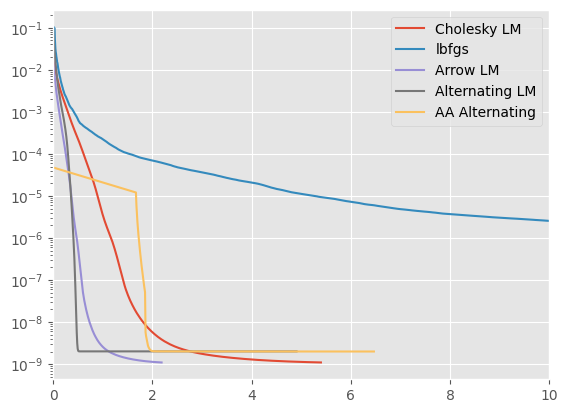

In [19]:
for name,c in convergence_results.items():
    times = c.cumulative_time
    plt.plot(times[1:] - times[1],c.loss_vals[1:],label = name)
plt.legend()
plt.yscale('log')
plt.xlim(0,10)